<a href="https://colab.research.google.com/github/MatienkoAndrew/notebooks/blob/main/%22SecondStepNLP_Word2Vec_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec

План:

* w2v from scratch
* обучаем w2v из коробки на своих данных
* используем обученный w2v и друзей

In [1]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.6 MB/s eta 0:00:00


In [2]:
!pip3 install pytorch_lightning torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 39.6 MB/s eta 0:00:00


### Импорт библиотек и загрузка данных

In [3]:
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader

# import torchvision
# import torchvision.transforms as transforms

# import pytorch_lightning as pl
# import datasets

# import text_helper

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import datasets

dataset = datasets.load_dataset('tweets_hate_speech_detection')

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

Dataset tweets_hate_speech_detection downloaded and prepared to /root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/d8cea5e82c610e1675eee6632345085d81875565ea46d24bdcd5a7f382e335ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 17197
    })
})

## Вспомогательный блок

* Разбиваем тексты на токены
* Создаем словарь и другие вспомогательные характеристики по текстам
* Убираем редкие токены
* Организуем скользящее окно

Реализация в файле text_helper.py

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
! pip install text_helper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement text_helper (from versions: none)
ERROR: No matching distribution found for text_helper


#### split_tokens

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import Counter

ss = SnowballStemmer('english')
sw = stopwords.words('english')

def split_tokens(row):
    row['all_tokens'] = [ss.stem(i) for i in 
                         re.split(r" +", 
                                  re.sub(r"[^a-z@# ]", 
                                         "", 
                                         row['tweet'].lower()
                                         )
                                  ) 
                         if (i not in sw) and len(i)
                         ]
    return row

In [39]:
sentences = [['i', 'love', 'you'], ['i', 'love', 'you1']]
test = Counter([word for sentence in sentences for word in sentence])

test
test.items()

Counter({'i': 2, 'love': 2, 'you': 1, 'you1': 1})

dict_items([('i', 2), ('love', 2), ('you', 1), ('you1', 1)])

#### get_info

In [63]:
def get_info(dataset):
    counts = Counter([word for sentence in dataset['train']['all_tokens'] for word in sentence])
    counts = {word: freq for word, freq in counts.items() if freq > 10}
    vocab = list(counts.keys())
    n_v = len(vocab)
    id2tok = dict(enumerate(vocab))
    tok2id = {tok: idx for idx, tok in id2tok.items()}
    return counts, vocab, n_v, id2tok, tok2id

#### remove_rare_tokens

In [64]:
def remove_rare_tokens(row, vocab):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

#### windowizer

In [72]:
def windowizer(row, tok2id, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j >= 0) &
                     (i + j < len(doc)) &
                     (j != 0)]
        out+=[(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

In [73]:
# import text_helper

dataset = dataset.map(split_tokens) # разбиваем текст на токены

counts, vocab, n_v, id2tok, tok2id = get_info(dataset) # получаем словарь и так далее

# counts - сколько раз встречается каждое слово в словаре
# vocab - список слов 
# n_v - количество слов в словаре
# id2tok, tok2id - соответствие слов и их индексов в словаре

dataset = dataset.map(lambda x: remove_rare_tokens(x, vocab)) # выкидываем редкие токены

dataset = dataset.map(lambda x: windowizer(x, tok2id, wsize=3)) # применяем функцию скользящего окна для обучения word2vec

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

In [116]:
dataset
print()
f"dataset['train']['tweet'][0]= {dataset['train']['tweet'][0]}"
print()
f"dataset['train']['all_tokens'][0]={dataset['train']['all_tokens'][0]}"
print()
f"dataset['train']['tokens'][0]={dataset['train']['tokens'][0]}"
print()
f"dataset['train']['moving_window'][0]={dataset['train']['moving_window'][0]}"

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 17197
    })
})

"dataset['train']['tweet'][0]= @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run"

"dataset['train']['all_tokens'][0]=['@user', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct', '#run']"

"dataset['train']['tokens'][0]=['@user', 'father', 'drag', 'kid', '#run']"

"dataset['train']['moving_window'][0]=[[0, 1], [0, 2], [0, 3], [1, 0], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 1], [4, 2], [4, 3]]"

## Создаем сеть

Для работы с датасетом в PyTorch (если мы не используем стандартные датасеты, которые уже есть в библиотеке) нужно создать класс для датасета, унаследованный от torch.utils.data.Dataset с методами:
* `__init__` — создаёт поля класса (например, путь к папке с файлами с тренировочными объектами)
* `__len__` - вычисление длины датасета
* `__getitem__` - доступ к объекту датасета по индексу.

### Word2VecDataset

In [118]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 17197
    })
})

In [121]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens', 'moving_window'],
        num_rows: 17197
    })
})

In [76]:
from torch.utils.data import Dataset

class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for sentence in dataset['moving_window'] for i in sentence]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

### DataLoader

In [81]:
from torch.utils.data import DataLoader

BATCH_SIZE = 2 ** 14
N_LOADER_PROCS = 10

train_dataloader = DataLoader(dataset=Word2VecDataset(dataset['train'], vocab_size=n_v),
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=N_LOADER_PROCS,
                              )

test_dataloader = DataLoader(dataset=Word2VecDataset(dataset['test'], vocab_size=n_v),
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=N_LOADER_PROCS,
                              )

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


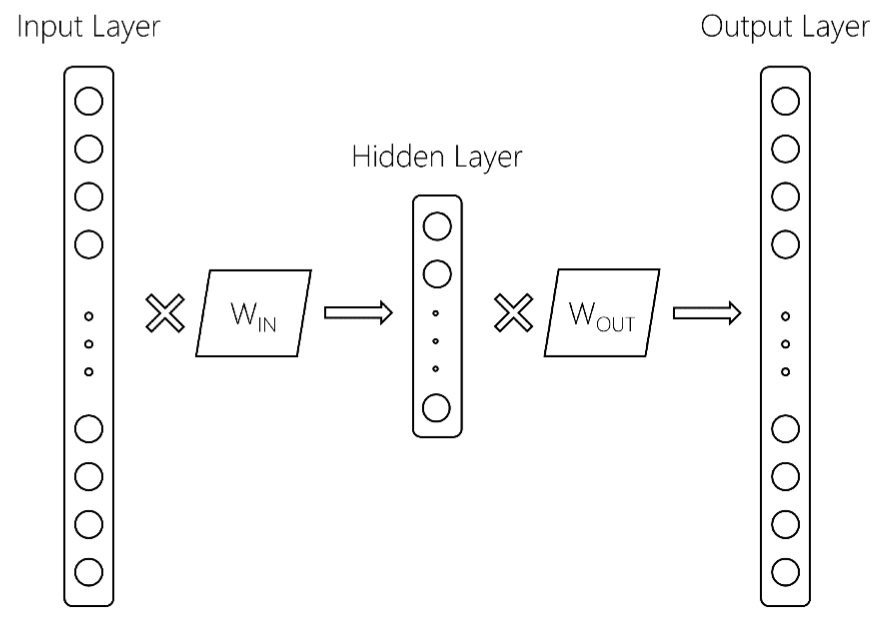

### Word2Vec

In [93]:
from torch import nn
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=embedding_size)
        self.linear = nn.Linear(in_features=embedding_size, 
                                out_features=vocab_size, 
                                bias=False)
        self.loss_func = nn.CrossEntropyLoss()

    def forward(self, x, targets=None):
        hidden = self.embed(x)
        logits = self.linear(hidden)

        if targets is not None:
            loss = self.loss_func(logits, targets) # вычисляем ошибку модели
            return logits, loss
        return logits

### LightningModule

In [85]:
import pytorch_lightning as pl

# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate) # вариант градиентного спуска, который мы используем
        return optimizer

    def training_step(self, train_batch, batch_idx): # шаг обучения: вычисляем лосс на батче
        center, context = train_batch
        _, loss = self.model(center, context)
        self.log("train_loss", loss, prog_bar=True)  # сохраняет логи в папку
        return loss

    def validation_step(self, val_batch, batch_idx): # шаг валидации - аналогичный
        center, context = val_batch
        _, loss = self.model(center, context)
        self.log("val_loss", loss, prog_bar=True)  # сохраняет логи в папку
        return loss

In [87]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # если есть gpu, то gpu
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

EPOCHS = 10 # число эпох
LR = 0.001 # learning rate 

In [94]:
# 2) create module

EMBED_SIZE = 100 # можно и больше

model = Word2Vec(n_v, EMBED_SIZE).to(device) # объявляем сеть, переносим ее на gpu 

module = SimpleModule( # объявляем модуль для обучения сети
    model,
    learning_rate=LR
)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer( # выбираем параметры обучения
    accelerator=accelerator,
    max_epochs=EPOCHS
)

trainer.fit(module, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | Word2Vec | 617 K 
-----------------------------------
617 K     Trainable params
0         Non-trainable params
617 K     Total params
2.468     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [95]:
wordvecs = module.model.linear.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']

## Анализ результатов

* `get_distance_matrix` - функция для вычисления матрицы расстояний между векторами
* `get_k_similar_words` - функция для вычисления $k$ ближайших по косинусной метрике слов к заданному

In [100]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric): # матрица расстояний между векторами слов
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10): # k ближайших слов к заданному
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')

for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['weather', 'bong', '#rip', 'ka', '#movi', 'noth', 'pain', '#live', 'amaz', '#instamood'] 

father ['today', 'person', 'fathersday', 'happen', 'life', 'last', 'sweet', 'rock', 'prepar', 'stun'] 

school ['need', 'blame', 'hill', 'announc', '#mentalhealth', 'attack', '#edm', '#film', '#monday', 'citi'] 

hate ['miss', 'famili', 'away', 'place', 'keep', 'amaz', 'write', 'weekend', '#craft', 'notic'] 



## Обучаем готовую архитектуру на своих данных

In [101]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=dataset['train']['tokens'], size=100, window=5)

In [102]:
model.wv['father']

array([ 0.52048874, -1.1872814 , -1.5727903 , -0.15623009,  0.3289467 ,
       -0.30339423, -0.9279352 , -1.6657574 , -1.1514982 ,  0.58390456,
        0.285755  , -0.1878596 ,  0.22015041, -1.0760251 , -0.93571126,
        1.130931  ,  0.2988915 ,  1.185889  ,  0.9112636 , -0.36526376,
        1.1579782 , -0.91068673,  0.78143585,  0.03586248, -1.3529476 ,
       -0.02159532, -1.7405553 ,  0.16469447,  0.9591794 , -0.50592464,
       -0.26737538, -0.36600164, -0.81042016, -1.173792  , -0.3753176 ,
        0.4926534 , -0.25122967, -0.4142817 , -0.6677136 ,  0.29415056,
       -0.14064752, -1.1814634 , -0.2681257 , -0.00285663,  0.29932654,
       -0.09931879,  0.41326234, -0.31301215, -1.8395813 ,  0.26603544,
        0.4266559 , -0.43791592,  0.97412294,  0.2885298 , -0.9269078 ,
        1.1421045 ,  0.06769998,  0.01812551,  0.39570677, -1.0969732 ,
        0.12546921, -0.19086432,  0.29386622, -0.20817682, -0.32113147,
        0.3821396 ,  0.9164884 ,  0.7542862 , -0.7807319 , -0.16

In [103]:
model.most_similar('father')

<ipython-input-103-160a51c678ed>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('father')


[('dad', 0.9889686703681946),
 ('wish', 0.9411594867706299),
 ('day', 0.9325845241546631),
 ('#fathersday', 0.9299290180206299),
 ('daddi', 0.9265549182891846),
 ('#father', 0.9114558696746826),
 ('#dad', 0.8978646397590637),
 ('gift', 0.8963487148284912),
 ('fathersday', 0.8913853168487549),
 ('special', 0.8886408805847168)]

## Используем предобученные модели

In [104]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [105]:
w2v_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [106]:
w2v_vectors['father']

array([-1.2006  ,  0.59454 ,  0.27821 ,  0.86424 ,  0.021296, -1.1184  ,
        1.1299  ,  0.26826 , -0.41652 , -0.22056 ,  0.203   ,  0.57734 ,
       -3.8551  ,  0.58745 , -0.21923 , -0.30499 ,  0.75124 ,  0.31219 ,
        0.29848 , -0.43404 ,  1.0534  ,  0.85965 , -0.90158 , -0.47079 ,
       -0.37878 ], dtype=float32)

In [107]:
w2v_vectors.most_similar('father')

[('mother', 0.9509678483009338),
 ('daughter', 0.9483673572540283),
 ('husband', 0.9278268814086914),
 ('child', 0.926058292388916),
 ('wife', 0.9247055053710938),
 ('whose', 0.9104864001274109),
 ('grandmother', 0.9046281576156616),
 ('woman', 0.9028054475784302),
 ('birth', 0.8912784457206726),
 ('called', 0.8850919604301453)]

In [108]:
new_vector = w2v_vectors['queen'] - w2v_vectors['woman'] + w2v_vectors['man']

In [109]:
w2v_vectors.most_similar(positive=[new_vector])

[('nat', 0.8628743886947632),
 ('man', 0.8274872303009033),
 ('tom', 0.8135090470314026),
 ('val', 0.7990008592605591),
 ('omg', 0.7952776551246643),
 ('ken', 0.7896935343742371),
 ('boom', 0.788312554359436),
 ('bam', 0.7844098210334778),
 ('nina', 0.7789903283119202),
 ('miss', 0.7762444615364075)]